In [4]:
try:
  import jax
except ModuleNotFoundError:
  % pip install jax 
  import jax

import GPy
import jax.numpy as jnp
key = jax.random.PRNGKey(42)
jax.config.update("jax_enable_x64", True)

try:
  import matplotlib.pyplot as plt
except ModuleNotFoundError:
  % pip install matplotlib 
  import matplotlib.pyplot as plt

import nbimporter
from GP_Scratch import GP_Regression

In [5]:
def data(num_points, test_points, key_, noise):

  X =  jnp.linspace(-4, 4, num_points).reshape(-1,1) 
  y = jnp.sin(X)

  test_points = 100
  X_test =  jnp.linspace(-5, 5, test_points).reshape(-1,1) 
  y_test = jnp.sin(X_test)

  if (noise):
    y = y + jax.random.normal(key = key_, shape = (num_points, 1)) * noise**0.5
    y_test = y_test + jax.random.normal(key = key_, shape = (test_points, 1)) * noise**0.5

  return X, y , X_test, y_test

In [6]:
def rbf(x, x_star, len_scale, sigmaf):
  return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  

kernel_ = GPy.kern.RBF(1)

rbf(jnp.array([[1]]), jnp.array([[0]]), 1, 1)==kernel_.K(jnp.array([[1]]), jnp.array([[0]])).flatten()

DeviceArray([[ True]], dtype=bool)

In [7]:
def periodic_kernel(x, xstar, len_scale, sigmaf, period):
  return (sigmaf**2)*(jnp.exp((-1/2*(len_scale**2)) * jnp.square(jnp.sin(jnp.pi * (x-xstar)/period))))

kernel_p = GPy.kern.StdPeriodic(1, (0.45)**2, 1.2, 1)

periodic_kernel(jnp.array([[1]]), jnp.array([[0]]), 1, 0.45, 1.2)==kernel_p.K(jnp.array([[1]]), jnp.array([[0]])).flatten()

DeviceArray([[ True]], dtype=bool)

In [14]:
def nll(X, y, len_scale, sigmaf, var_y):

  N = X.shape[0]
  k_sigma1 = rbf(X, X.T, len_scale, sigmaf) + ((var_y) * jnp.eye(X.shape[0]))
  k_sigma2 =periodic_kernel(X, X.T, len_scale, sigmaf, 1.2) + ((var_y) * jnp.eye(X.shape[0]))
  k_sigma = k_sigma1
  L = jnp.linalg.cholesky(k_sigma)
  alpha = jnp.linalg.solve(L.T, jnp.linalg.solve(L,y))
  neg_log_likelihood = 0.5*jnp.dot(y.T, alpha) + jnp.trace(jnp.log(L)) + 0.5*(N*jnp.log(2*jnp.pi))
  return neg_log_likelihood[0,0]

In [15]:
X, y, X_test, y_test = data(7, 100, key, noise = 1)
nll(X, y, 1.33,1, 0.45)


DeviceArray(18.40615528, dtype=float64)

### Applying Gradient Descent

1.33 0.18757758359354137 3.306727975471677
9999 14.160253781550024
0.667 0.15274627475487687 3.2623443763951596
9999 14.150680937051526
0.44 1.2682584233228358 1.7284976281001778
9999 14.153519513679528
0.33 1.6170750458470902 0.7213965748169029
9999 14.149624561460499


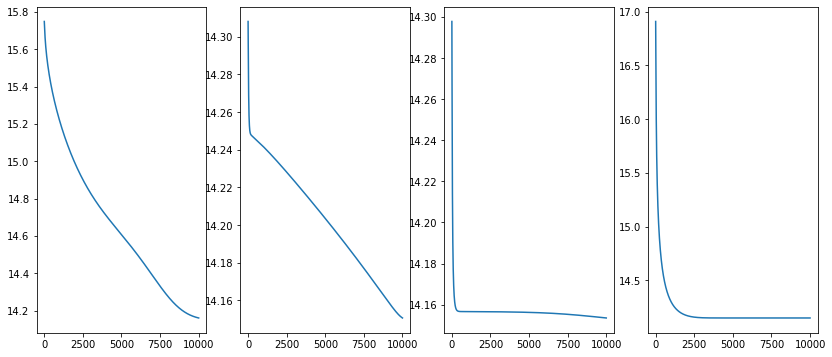

In [21]:
# initial paramters
max_iters = int(10e3)
lr = 0.001
nll_iters = []
X, y, X_test, y_test = data(7, 100, key, noise = 1)


# Trying for multiple values

len_scale_arr = [1.33,0.667, 0.44, 0.33]
sigmaf_arr = [3.3, 2., 1.5, 1.]
sigmay_arr = [0.45, 0.23, 0.3, 0.18]

# Using jax.grad
nll_gradient = jax.grad(nll, argnums=[2,3,4])

# iterations
nll_iters_final= []
nll_iters_min = []
nll_params = []

# Using adam optimizer
from jax.experimental import optimizers

fig, ax = plt.subplots(1,4,figsize=(14,6))

for j in range(4):
  len_scale = len_scale_arr[j]
  sigmaf = sigmaf_arr[j]
  sigmay = sigmay_arr[j]
  nll_iters = []
  opt_init, opt_update, get_params = optimizers.adam(lr)
  opt_state = opt_init((len_scale, sigmaf, sigmay))

  for i in range(max_iters):
    nll_iters.append(nll(X, y, len_scale, sigmaf, sigmay))
    grads = nll_gradient(X, y, len_scale, sigmaf, sigmay)
    opt_state = opt_update(0, grads, opt_state)
    len_Scale, sigmaf, sigmay = get_params(opt_state)

  nll_iters = jnp.array(nll_iters)
  ax[j].plot(nll_iters)
  
  print(len_scale, sigmaf, sigmay)
  print(jnp.argmin(nll_iters), nll_iters[-1])
  nll_iters_final.append(nll_iters[-1])
  nll_iters_min.append(jnp.min(nll_iters))
  nll_params.append([len_scale, sigmaf, sigmay])

In [17]:
min_index = jnp.argmin(jnp.array(nll_iters_final))
len_scale_opt, sigmaf_opt, sigmay_opt = nll_params[min_index]
print(len_scale_opt, sigmaf_opt, sigmay_opt)

0.33 1.6178036021609548 0.7190400732290397


In [18]:
class GP_Regression:
  
  def __init__(self, len_scale, sigmaf):
    self.len_scale = len_scale
    self.sigmaf = sigmaf

  def rbf(self, x, x_star, len_scale, sigmaf):
    return (sigmaf**2)*(jnp.exp(-(x-x_star)**2/(2*(len_scale**2))))  

  def posterior(self, X, y, X_test, mu_prior, sigmay):
    k = self.rbf(X,X.T,self.len_scale, self.sigmaf)
    k = k + (sigmay * jnp.eye(len(X)))
    L = jnp.linalg.cholesky(k)
    kstar = self.rbf(X, X_test.T, self.len_scale, self.sigmaf)
    kstar_star = self.rbf(X_test, X_test.T, self.len_scale, self.sigmaf)

    # posterior mean
    alpha = jnp.linalg.solve(L.T, (jnp.linalg.solve(L, (y - mu_prior))))
    self.mu_posterior =  mu_prior + jnp.dot(kstar.T, alpha)

    # posterior covarinace
    v = jnp.linalg.solve(L, kstar)
    self.cov_posterior = kstar_star - jnp.dot(v.T, v)

    return self.mu_posterior, self.cov_posterior

  def posterior_samples(self, key, test_points, samples):
    # prior mean equal to zero
    f_post = self.mu_posterior.reshape(-1,1) + jnp.dot(self.cov_posterior, jax.random.normal(key = key, shape = (test_points, samples)))

    return f_post

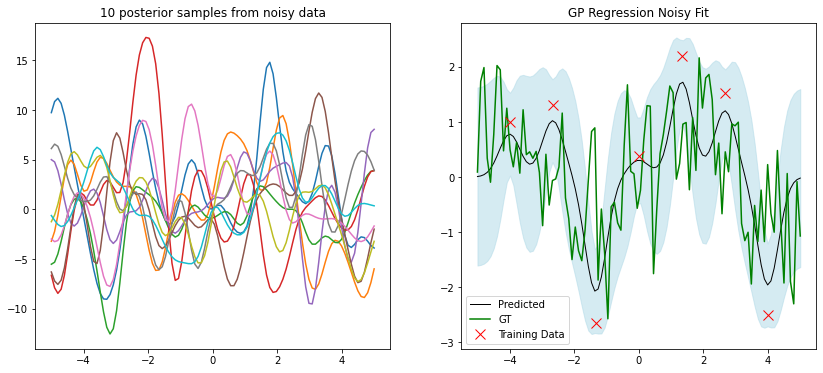

In [20]:
# noise_variance = 0.3
X, y, X_test, y_test = data(7, 100, key, noise = 1.)

GPR_noise = GP_Regression(len_scale_opt, sigmaf_opt)
mu_posterior_noisy, cov_posterior_noisy = GPR_noise.posterior(X, y, X_test, 0, sigmay_opt)

fig, ax = plt.subplots(1,2,figsize=(14,6))

# 10 posterior samples
f_post = GPR_noise.posterior_samples(key, 100, 10)
ax[0].plot(X_test, f_post)
ax[0].set_title("10 posterior samples from noisy data")

# plot showing mean and covaraince of 
ax[1].plot(X_test, mu_posterior_noisy,'k',label='Predicted',lw=1)
ax[1].plot(X_test, y_test, 'g',label='GT',lw=1.5)
ax[1].plot(X, y, 'x', c = 'r', markersize=10, label='Training Data')

ax[1].fill_between(X_test.flatten(), 
                 (mu_posterior_noisy.flatten() - jnp.sqrt(cov_posterior_noisy.diagonal().flatten())),
                 (mu_posterior_noisy.flatten() + jnp.sqrt(cov_posterior_noisy.diagonal().flatten())),
                 color='lightblue', alpha=0.5)
plt.legend()
ax[1].set_title("GP Regression Noisy Fit")
# plt.savefig("GP_noisy_posterior.png")
plt.show()